In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load your data
df = pd.read_csv("data_for_algo1")

# Feature engineering: compute ratios and deltas that might signal fraud
df["Cost_Diff"] = df["Rev_Cost"] - df["Org_Cost"]
df["Cost_Ratio"] = df["Rev_Cost"] / (df["Org_Cost"] + 1)
df["Exp_Cost_Ratio"] = df["Expenditure"] / (df["Org_Cost"] + 1)

# Drop non-numeric or high-cardinality text columns for modeling
numeric_df = df.select_dtypes(include=["float64", "int64"]).drop(columns=["SNo"], errors="ignore")

# Fill missing values and scale features
numeric_df = numeric_df.fillna(numeric_df.median())
scaled_data = StandardScaler().fit_transform(numeric_df)


In [2]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.05, random_state=42)
df["anomaly_score"] = iso.fit_predict(scaled_data)
df["anomaly_score"] = df["anomaly_score"].map({1: 0, -1: 1})  # 1 = anomaly

In [3]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
labels = lof.fit_predict(scaled_data)
df["lof_score"] = (labels == -1).astype(int)

d:\Desktop\Hackathon\env\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_dim = scaled_data.shape[1]
autoencoder = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(input_dim,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(input_dim, activation='linear')
])
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(scaled_data, scaled_data, epochs=50, batch_size=16, verbose=0)

recon = autoencoder.predict(scaled_data)
recon_error = ((scaled_data - recon) ** 2).mean(axis=1)
df["recon_error"] = recon_error


d:\Desktop\Hackathon\env\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [5]:
df["combined_anomaly"] = (
    0.4 * df["anomaly_score"] +
    0.3 * df["lof_score"] +
    0.3 * (df["recon_error"] > df["recon_error"].quantile(0.95)).astype(int)
)

In [6]:
suspicious = df.sort_values("combined_anomaly", ascending=False).head(50)

In [7]:
suspicious

,SNo,State,Expenditure,Progress,Project_Name,Agency,Dateof_Approval,Start_Date,Org_DoC,Rev_DoC,Org_Cost,Rev_Cost,Cost_Diff,Cost_Ratio,Exp_Cost_Ratio,anomaly_score,lof_score,recon_error,combined_anomaly
884,788.0,Odisha,2629.74,62.0,Integrated Anandpur Barrage Project,Water Resources-OR,NaN,01/1998,12/2019,06/2026,567.03,2990.05,2423.02,5.263895,4.629579,1,1,0.006832,1.0
894,797.0,Uttar Pradesh,3218.30,100.0,Arjun Sahayak Project,Irrigation & Water Resources-UP,NaN,04/2009,12/2019,12/2019,741.38,2465.68,1724.30,3.321318,4.335111,1,1,0.009018,1.0
840,749.0,PAN India,41486.14,81.0,BharatNet,Department of Telecommunications [DoT],07/2017,10/2011,08/2023,03/2027,61109.00,188000.00,126891.00,3.076420,0.678876,1,1,1.445677,1.0
839,748.0,PAN India,8390.32,96.0,4G Services by BSNL,Department of Telecommunications [DoT],11/2020,11/2020,03/2024,03/2026,28466.00,19592.00,-8874.00,0.688236,0.294738,1,1,0.043502,1.0
859,763.0,Andhra Pradesh,24347.76,83.0,Polavaram Irrigation Project,Water Resources-AP,02/2009,11/2004,04/2022,03/2026,10151.04,55548.90,45397.86,5.471698,2.398312,1,1,0.092837,1.0
716,637.0,All India,124623.00,96.0,Western Dedicated Freight Corridor,DFCCIL,02/2008,01/2012,03/2022,12/2025,51101.00,124005.00,72904.00,2.426617,2.438711,1,1,0.156490,1.0
712,633.0,All India,79918.89,53.0,Mumbai-Ahmedabad High Speed Rail Project- 508 km,National High Speed Rail Corporation [NHSRC],03/2015,09/2017,08/2027,12/2029,108000.00,108000.00,0.00,0.999991,0.739983,1,1,0.055379,1.0
880,784.0,Maharashtra,1324.78,64.0,Lower Pedhi Project,Department of water resources-MH - II,NaN,04/2008,12/2019,06/2026,255.97,1480.70,1224.73,5.762151,5.155388,1,1,0.015845,1.0
386,342.0,All India,60295.14,88.0,Rajasthan Refinery Project,MinistryofPetroleumNaturalGas,NaN,10/2017,10/2022,03/2026,43129.00,79459.00,36330.00,1.842314,1.397986,1,1,0.047424,1.0
879,783.0,Maharashtra,1697.94,97.0,Aruna Medium Irrigation Project,Department of water resources-MH - II,NaN,01/2010,12/2019,12/2025,210.45,1472.14,1261.69,6.962119,8.029983,1,1,0.017626,1.0


d:\Desktop\Hackathon\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


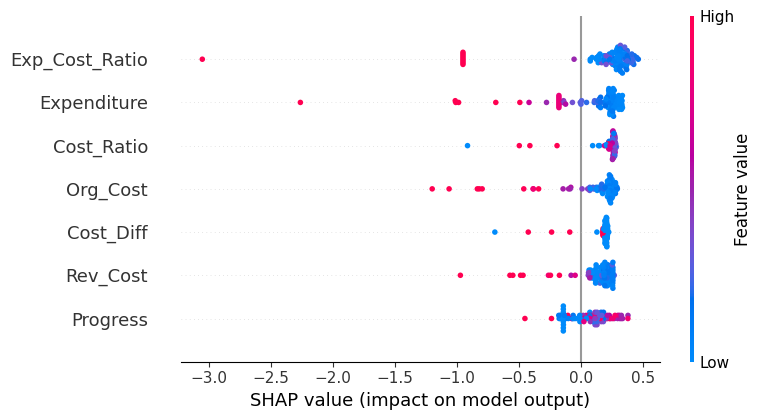

In [8]:
import shap
explainer = shap.Explainer(iso)
shap_values = explainer(scaled_data[:100])
shap.summary_plot(shap_values, numeric_df.iloc[:100])


In [9]:
df.to_csv("data_for_algo2", index=False)

In [10]:
df.to_csv("anamoly_flagged_data.csv", index=False)